<a href="https://colab.research.google.com/github/evi03/MechineLearning/blob/main/Mechine_Learning_JS10_EVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NAMA: EVI AMALIA MIDFIA**

**KELAS: TI-3A**

**ABSEN: 13**

**NIM: 2141720030**

# **PRAKTIKUM 1**

**Setup**

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
 plt.plot(history.history[metric])
 plt.plot(history.history['val_'+metric], '')
 plt.xlabel("Epochs")
 plt.ylabel(metric)
 plt.legend([metric, 'val_'+metric])

**Setup input pipeline**

Download dataset menggunakan TFDS.

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'Edward Burtynsky is a Canadian photographer who makes art out of the least "artful" objects imaginable. Everyday items such as crates, boxes, metal containers, etc. - items which most of us perceive as utilitarian at best and dismiss as being utterly without aesthetic merit - are instead converted into glorious objects d\'art by Burtynsky\'s camera. He achieves this result by focusing on the recurring colors and geometric patterns that are apparently ever present in the industrialized world - for those perceptive enough to spot them, that is. Even heaps of compacted trash can become objects of beauty when seen through Burtynsky\'s lens (but didn\'t we already know that from "Wall-E"?). He is particularly interested in photographing areas like mines and shipyards where Man has already made incursions into nature - which may explain why at times even the people in his pictures (i.e. the workers in those places), with their uniform clothing and robotic movements, become part of

**Buat Teks Encoder**

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[  1,   1,   7, ...,   0,   0,   0],
       [  8,   1,   4, ...,   0,   0,   0],
       [ 51, 147, 111, ...,   0,   0,   0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Edward Burtynsky is a Canadian photographer who makes art out of the least "artful" objects imaginable. Everyday items such as crates, boxes, metal containers, etc. - items which most of us perceive as utilitarian at best and dismiss as being utterly without aesthetic merit - are instead converted into glorious objects d\'art by Burtynsky\'s camera. He achieves this result by focusing on the recurring colors and geometric patterns that are apparently ever present in the industrialized world - for those perceptive enough to spot them, that is. Even heaps of compacted trash can become objects of beauty when seen through Burtynsky\'s lens (but didn\'t we already know that from "Wall-E"?). He is particularly interested in photographing areas like mines and shipyards where Man has already made incursions into nature - which may explain why at times even the people in his pictures (i.e. the workers in those places), with their uniform clothing and robotic movements, become part 

**Buat Model**

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 8s 8s/step
[0.00336567]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 60ms/step
[0.00336567]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Train Model**

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 51s 103ms/step - loss: 0.6546 - accuracy: 0.5568 - val_loss: 0.5462 - val_accuracy: 0.6724
Epoch 2/10
391/391 [==============================] - 27s 68ms/step - loss: 0.4395 - accuracy: 0.7920 - val_loss: 0.4033 - val_accuracy: 0.8344
Epoch 3/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3600 - accuracy: 0.8409 - val_loss: 0.3554 - val_accuracy: 0.8448
Epoch 4/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3324 - accuracy: 0.8570 - val_loss: 0.3397 - val_accuracy: 0.8464
Epoch 5/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3163 - accuracy: 0.8671 - val_loss: 0.3287 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3085 - accuracy: 0.8692 - val_loss: 0.3263 - val_accuracy: 0.8620
Epoch 7/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3034 - accuracy: 0.8725 - val_loss: 0.3245 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3143 - accuracy: 0.8635
Test Loss: 0.3142513930797577
Test Accuracy: 0.8635200262069702


(0.0, 0.6724949419498444)

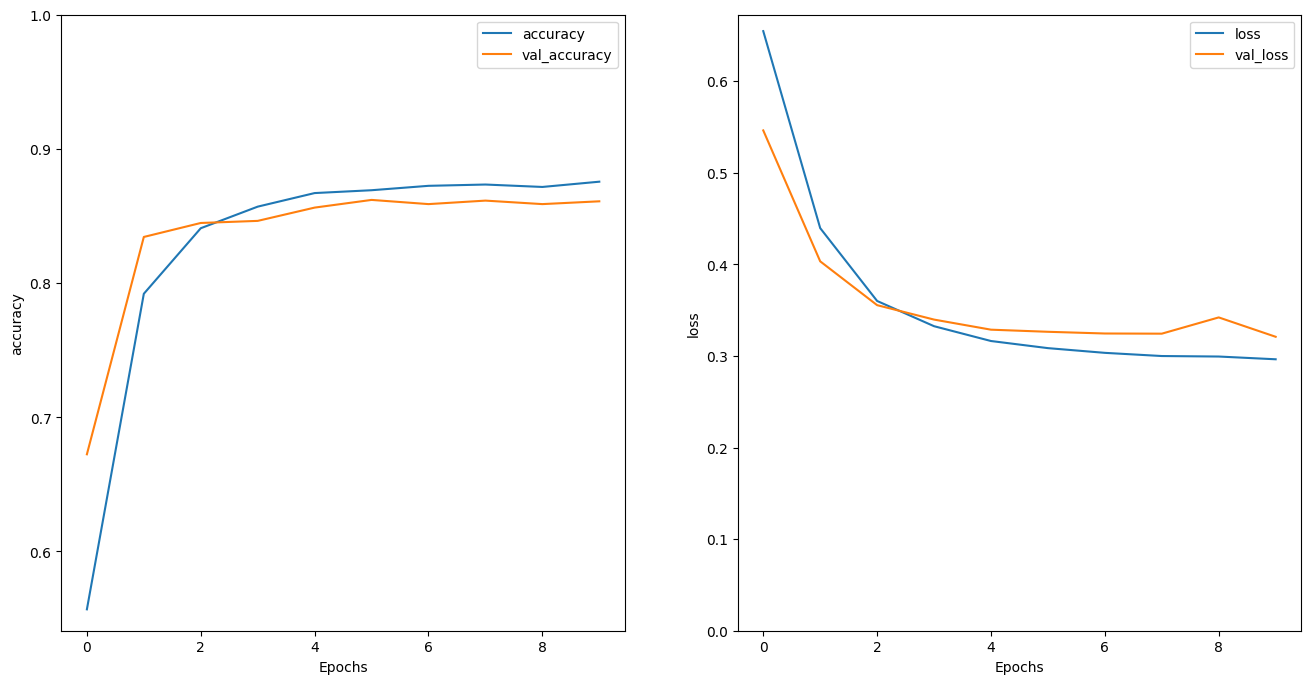

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:
Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


**Stack two or more LSTM layers**

In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 78s 154ms/step - loss: 0.6433 - accuracy: 0.5648 - val_loss: 0.4544 - val_accuracy: 0.7911
Epoch 2/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3934 - accuracy: 0.8234 - val_loss: 0.3661 - val_accuracy: 0.8281
Epoch 3/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3394 - accuracy: 0.8538 - val_loss: 0.3427 - val_accuracy: 0.8432
Epoch 4/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3211 - accuracy: 0.8628 - val_loss: 0.3253 - val_accuracy: 0.8573
Epoch 5/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3161 - accuracy: 0.8652 - val_loss: 0.3230 - val_accuracy: 0.8589
Epoch 6/10
391/391 [==============================] - 48s 123ms/step - loss: 0.3074 - accuracy: 0.8697 - val_loss: 0.3181 - val_accuracy: 0.8578
Epoch 7/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3024 - accuracy: 0.8690 - val_loss: 0.3256 - val_ac

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 48ms/step - loss: 0.3213 - accuracy: 0.8528
Test Loss: 0.3212982714176178
Test Accuracy: 0.8528000116348267


In [23]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.998014]]


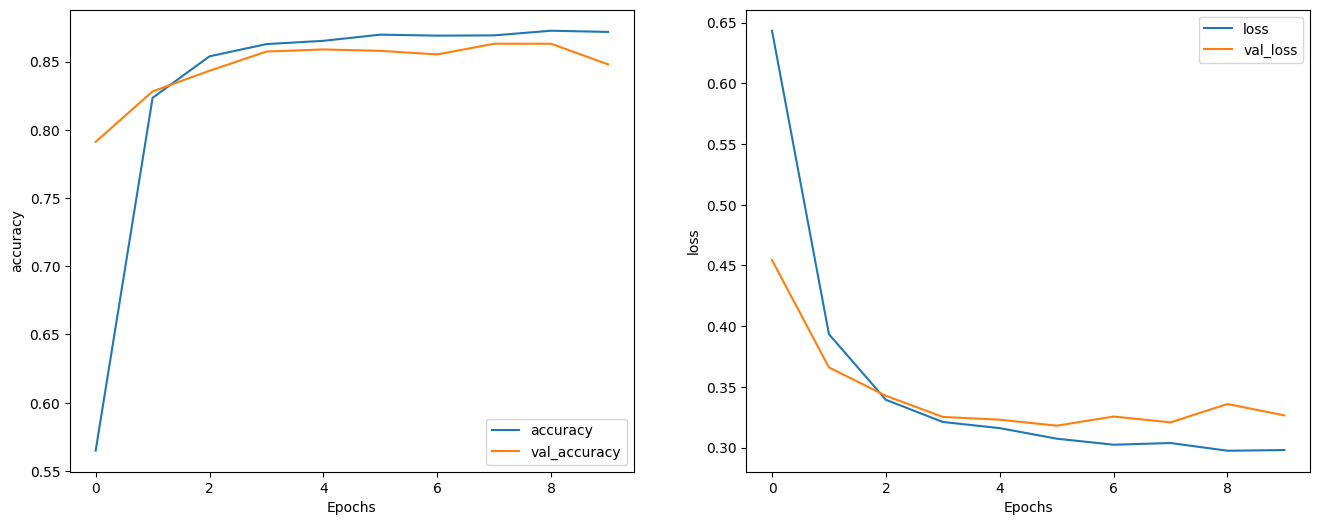

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# **PRAKTIKUM 2**


**Setup**

Import TensorFlow

In [25]:
import tensorflow as tf
import numpy as np
import os
import time

Download Dataset Shakespeare

In [31]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


Load Data

In [32]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [33]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [34]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


**Olah Teks**

Vectorize Teks

In [35]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [36]:
# sekarang buat tf.keras.layers.StringLookup layer:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

In [37]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [38]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [39]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [40]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [41]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

Prediksi, Membuat Trianing Set dan Target

In [44]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [45]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [46]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [48]:
seq_length = 100

In [49]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [50]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [51]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [52]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [53]:
dataset = sequences.map(split_input_target)

In [54]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Membuat Batch Training

In [55]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

**Buat Model**

tf.keras.layers.Embedding: Lapisan masukan. Tabel pencarian yang dapat dilatih yang akan memetakan setiap karakter-ID ke vektor dengan dimensi embedding_dim;

In [56]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

tf.keras.layers.GRU: lapisan RNN dengan ukuran unit=rnn_units (Anda juga dapat menggunakan lapisan LSTM di sini.)

In [57]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

tf.keras.layers.Dense: Lapisan keluaran, dengan keluaran vocab_size. Ini menghasilkan satu logit untuk setiap karakter dalam kosakata. Ini adalah log kemungkinan setiap karakter menurut model.

In [58]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

**Uji Model**

Cek bentuk dari output

In [59]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


Masukan dengan panjang berapa pun

In [60]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Mengambil sampel dari distribusi keluaran

In [61]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

Prediksi indeks karakter berikutnya

In [62]:
sampled_indices

array([52, 30, 48, 47, 19,  4, 18, 53, 25, 63, 61, 61, 44, 61, 21, 18, 32,
       59, 30, 58, 41, 18, 11, 29, 38,  6, 53, 22, 38, 26, 52, 16, 43, 53,
        1, 28, 11, 59, 54, 42, 12, 29, 22, 62, 43, 11, 10,  0,  6, 31, 37,
        3,  3, 40, 19, 36, 32, 65, 20, 30, 45, 37, 38, 36,  1, 30, 15, 10,
       25, 16, 65, 14, 45, 13, 51, 50, 31, 34, 20, 62, 13, 53, 62, 50, 24,
       64, 27, 19, 41, 12, 31, 45,  6, 38, 40,  7, 28, 50, 19, 37])

Melihat teks yang diprediksi oleh model tidak terlatih ini

In [63]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b" hath press'd\nTo lift shrewd steel against our golden crown,\nGod for his Richard hath in heavenly pa"

Next Char Predictions:
 b"mQihF$EnLxvvevHEStQsbE:PY'nIYMmCdn\nO:toc;PIwd:3[UNK]'RX!!aFWSzGQfXYW\nQB3LCzAf?lkRUGw?nwkKyNFb;Rf'Ya,OkFX"


**Train Model**

Tambahan optimizer dan fungsi loss

In [64]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [65]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.187448, shape=(), dtype=float32)


In [66]:
tf.exp(example_batch_mean_loss).numpy()

65.854515

In [68]:
model.compile(optimizer='adam', loss=loss)

Konfigurasi Checkpoints

In [69]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

Lakukan Proses Training

In [70]:
EPOCHS = 20

In [71]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 16s 59ms/step - loss: 2.6854
Epoch 2/20
172/172 [==============================] - 12s 58ms/step - loss: 1.9643
Epoch 3/20
172/172 [==============================] - 12s 57ms/step - loss: 1.6883
Epoch 4/20
172/172 [==============================] - 13s 60ms/step - loss: 1.5305
Epoch 5/20
172/172 [==============================] - 14s 60ms/step - loss: 1.4344
Epoch 6/20
172/172 [==============================] - 13s 59ms/step - loss: 1.3675
Epoch 7/20
172/172 [==============================] - 12s 59ms/step - loss: 1.3154
Epoch 8/20
172/172 [==============================] - 12s 56ms/step - loss: 1.2695
Epoch 9/20
172/172 [==============================] - 13s 57ms/step - loss: 1.2290
Epoch 10/20
172/172 [==============================] - 13s 59ms/step - loss: 1.1879
Epoch 11/20
172/172 [==============================] - 11s 56ms/step - loss: 1.1478
Epoch 12/20
172/172 [==============================] - 11s 57ms/step - loss: 1.1055
E

**Generate Teks**

In [73]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [74]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [75]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Not her held nor wall; if I talk not in heaven,
As 'twere i' the stealing hooping lips and honour,
And you the noble uncle, that will take this offence;
Like potion. I say unto the seas
Which in the enemy as to fick prayer about
you.

LEONTES:
Would he die, and let them in the mode
And straight able. Wherefore he can part in mine eyes!
Is he not wonder? Now, dastening, peace,
Plats cirit the simple garments Show,
At their bed chastised he
hard--you on your lasting wretches shall be, in heaven I'll keep
Cutibing to pieces on the wormertain's wall obly his
jecume: condemn it.

LUCIO:
And I thank you.

LUCIO:
I would true, may: this is no dalled son.
See, so within! let us to the house of York.
Now 'tis a sport in-labiant manage with me well
persuade him to dive into his wood, and bring it yet.
Mayst thou legs unto himself?

LEONTES:
Wouldst thou denied to Rome
Thy tears are up, and privily each pawn
The water and unfected lewds
And sceptre what dispuble bloody bexasing weal,
And t

In [76]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nArt thou as just, as it heart I have disproved in thee\nAs own praying prepared Warwick,' did bride it with coniection.\nSix yield me in the use on thee, 'think prove sleep,\nTrust, pity, sir, a foolm and rings\nto the Capitol-witness.\n\nProvost:\nLest is your good duked has been to't,--\nAnd here in these extilediest sweet blood swear your life\nAs we have stain'd a mility: only for the\nfeeling-surpruitions from the rivery of the women\nBeet us in foreign your garland. Would I weed, Sir\nHaply more executioner you here.\nSay, what an old traitor paid it bring,\none number, suffer't, being outrage, ere too much\nHe can some vanter. But now 'tis face:\nDid I in being none, as I can, yes, I\ndeliver'd my viewing mothers and good night?\nI am painted, dress'd in your find three cheeks,\nWife to 'fore thee refenself, that I my lord.\n\nKING EDWARD IV:\nHady this dread time to France,' date of marriage, nor of\nthines that do lack discontented hum.\n\nMARIANA:\nBy th

**Ekspor Model Generator**

In [77]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [78]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Soft, sir! here, sir, nor all the blood of these griefs!

YORK:
My fair is accursed; when you call 


# **TUGAS**

**Prosedurnya adalah:**


1. Jalankan Model dan hitung loss dengan tf.GradientTape.

2. Hitung update dan terapkan pada model dengan optimizer

In [79]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
          grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

> Kode diatas menerapkan train_step method sesuai dengan  Keras' train_step conventions. Ini opsional, tetapi memungkinkan Anda mengubah perilaku langkah pelatihan dan tetap menggunakan keras Model.compile and Model.fit methods.



In [80]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [81]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [82]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 16s 57ms/step - loss: 2.7306




> Atau jika ingin lebih mengetahui dalamnya, kita bisa membuat custom training loop sendiri:



In [83]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

# saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1852
Epoch 1 Batch 50 Loss 2.0770
Epoch 1 Batch 100 Loss 1.9767
Epoch 1 Batch 150 Loss 1.8728

Epoch 1 Loss: 1.9967
Time taken for 1 epoch 12.98 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8339
Epoch 2 Batch 50 Loss 1.7252
Epoch 2 Batch 100 Loss 1.6974
Epoch 2 Batch 150 Loss 1.6561

Epoch 2 Loss: 1.7159
Time taken for 1 epoch 20.47 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.6371
Epoch 3 Batch 50 Loss 1.5537
Epoch 3 Batch 100 Loss 1.5625
Epoch 3 Batch 150 Loss 1.5179

Epoch 3 Loss: 1.5554
Time taken for 1 epoch 11.21 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4405
Epoch 4 Batch 50 Loss 1.4631
Epoch 4 Batch 100 Loss 1.4582
Epoch 4 Batch 150 Loss 1.4008

Epoch 4 Loss: 1.4560
Time taken for 1 epoch 11.11 sec
_____________________________________________________________________

3. Jalankan kode diatas dan sebutkan perbedaanya dengan praktikum 2?

Terdapat beberapa perbedaan utama antara praktikum 2 dan pelatihan tugas yang jalankan:

**1. Model Architectures:**

* Praktikum 2 menggunakan model bahasa berdasarkan RNN (Recurrent Neural Network), sementara pelatihan tugas mungkin menggunakan arsitektur yang berbeda, seperti GRU (Gated Recurrent Unit) dalam model .
*Praktikum 2 mungkin lebih sederhana dalam hal arsitektur model karena digunakan sebagai demonstrasi dasar. Model pelatihan tugas tampaknya memiliki lapisan embedding, lapisan GRU, dan lapisan dense.

**2. Epochs:**

* Dalam praktikum 2, menjalankan model selama 20 epoch, sedangkan dalam pelatihan tugas , melatih model selama 10 epoch.

**3. Prosedur Pelatihan:**

* Praktikum 2 mungkin lebih sederhana dalam hal pelatihan dan menggunakan API model.fit() bawaan Keras.
* Dalam pelatihan tugas , mengimplementasikan loop pelatihan khusus dengan menggunakan train_step, yang memberikan lebih banyak kontrol atas proses pelatihan, seperti pengukuran loss, perhitungan gradien, dan optimasi.

**4. Output Hasil Pelatihan:**

* Hasil dari praktikum 2 adalah informasi singkat tentang loss selama pelatihan tanpa informasi lebih lanjut tentang perbedaan antar epoch atau waktu eksekusi.
* Dalam pelatihan tugas , mencantumkan loss untuk setiap batch dan untuk setiap epoch, serta waktu yang diperlukan untuk menjalankan setiap epoch.

**5. Waktu Eksekusi:**

* Waktu eksekusi per epoch mungkin berbeda di antara kedua eksperimen karena praktikum 2 mungkin lebih cepat dalam pengaturan default, sedangkan dalam pelatihan tugas, waktu eksekusi mungkin lebih lama karena menjalankan model selama lebih banyak epoch.
Produk